In [1]:
import cv2
import torchinfo
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader

In [2]:
import io
import imageio
from tqdm import tqdm
from avi_r import AVIReader
import matplotlib.pyplot as plt
from ipywidgets import widgets, HBox

In [3]:
import os
import torch
import torch.nn as nn

In [4]:
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"

In [5]:
class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

In [6]:
class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output

In [7]:
class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, num_layers):

        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 

        # Add rest of the layers
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, frame_size=frame_size)
                )
                
            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                ) 

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        # Forward propagation through all the layers
        output = self.sequential(X)

        # Return only the last output frame
        output = self.conv(output[:,:,-1])
        
        return nn.Sigmoid()(output)

In [8]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
device

device(type='cuda')

In [11]:
master_path = '/home/staditya/Desktop/Pushkal/IVP Project/ConvLSTM/Walking/'
file_names = os.listdir(master_path)

WalkingDataset = []
min_frame = np.inf

for file in file_names:
    images = []
    video = AVIReader(master_path + file) 
    for frame in video:
        image = frame.numpy()
        images.append(rgb2gray(image))
    video.close()
    images = np.array(images)
    if images.shape[0] < min_frame:
        min_frame = images.shape[0]
    WalkingDataset.append(np.array(images[:395]))   
WalkingDataset = np.array(WalkingDataset, dtype = 'float32')
np.save('walking_dataset.npy', WalkingDataset)    

In [13]:
min_frame

In [14]:
train_frames = 75
seed = np.random.randint(0,350 - train_frames)
WalkingDataset = np.load('walking_dataset.npy')[:, seed:seed+train_frames]
print(seed)
fps = int(WalkingDataset.shape[1] / 5)
print(WalkingDataset.shape)
np.random.shuffle(WalkingDataset)

171
(100, 75, 120, 160)


In [16]:
rand_tr = 0
rand_tr = np.random.randint(rand_tr,70)
# rand_tr += 20
train_data = WalkingDataset[rand_tr:rand_tr+20]         
val_data = WalkingDataset[rand_tr+20:rand_tr+25]       
test_data = WalkingDataset[rand_tr+25:rand_tr+30]  

In [17]:
rand_tr

66

In [18]:
def collate(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     
    
    # Randomly pick 60 frames as input, 61st frame is target
    rand = np.random.randint(60,75)                     
    return batch[:,:,rand-60:rand], batch[:,:,rand]     


# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, 
                        batch_size=1, collate_fn=collate)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, 
                        batch_size=2, collate_fn=collate)

In [19]:
# Get a batch
input, _ = next(iter(val_loader))

# Reverse process before displaying
input = input.cpu().numpy() * 255.0     

for video in input.squeeze(1)[:3]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=fps)
        display(HBox([widgets.Image(value=gif.getvalue())]))

/tmp/ipykernel_23203/2232656256.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  batch = torch.tensor(batch).unsqueeze(1)


In [20]:
input.shape

(2, 1, 60, 120, 160)

In [21]:
input.dtype

dtype('float32')

In [22]:
# The input video frames are grayscale, thus single channel
model = Seq2Seq(num_channels=1, num_kernels=40, 
kernel_size=(3, 3), padding=(1, 1), activation="relu", 
frame_size=(120, 160), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.BCELoss(reduction='sum')
# model.load_state_dict(torch.load("/home/staditya/Desktop/Pushkal/IVP Project/ConvLSTM/walking_50_ep.pth"))

In [23]:
num_epochs = 50
tr_loss = []
valid_loss = []
for epoch in range(1, num_epochs+1):
    pbar = tqdm(total=len(train_loader), position=0, leave=True)
    train_loss = 0                                                 
    model.train()                                                  
    for batch_num, (input, target) in enumerate(train_loader, 1):  
        output = model(input)                                     
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()
        pbar.update(1)
    train_loss /= len(train_loader.dataset)                       

    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:                          
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()                                
    val_loss /= len(val_loader.dataset)                            

    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(
        epoch, train_loss, val_loss))
    tr_loss.append(train_loss)
    valid_loss.append(val_loss)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.37s/it]

Epoch:1 Training Loss:13373.27 Validation Loss:13289.30



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]

Epoch:2 Training Loss:12959.11 Validation Loss:13224.64



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]

Epoch:3 Training Loss:12777.46 Validation Loss:13106.11



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:4 Training Loss:12691.22 Validation Loss:12706.88



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:5 Training Loss:12589.74 Validation Loss:12618.25



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]

Epoch:6 Training Loss:12566.75 Validation Loss:12806.68



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]

Epoch:7 Training Loss:12468.58 Validation Loss:12456.46



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]

Epoch:8 Training Loss:12398.44 Validation Loss:12439.71



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]

Epoch:9 Training Loss:12286.75 Validation Loss:12743.29



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]

Epoch:10 Training Loss:12206.23 Validation Loss:12831.71



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:11 Training Loss:12713.10 Validation Loss:15992.05



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]

Epoch:12 Training Loss:13743.74 Validation Loss:21662.69



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch:13 Training Loss:13591.91 Validation Loss:28820.69



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:14 Training Loss:13212.61 Validation Loss:54937.22



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:15 Training Loss:13030.01 Validation Loss:46282.42



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:16 Training Loss:12990.85 Validation Loss:43805.97



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch:17 Training Loss:12923.76 Validation Loss:67140.70



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch:18 Training Loss:12925.48 Validation Loss:36366.93



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:19 Training Loss:12849.77 Validation Loss:64807.09



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:20 Training Loss:12854.96 Validation Loss:39267.94



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch:21 Training Loss:12819.51 Validation Loss:45523.95



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch:22 Training Loss:12784.33 Validation Loss:41389.56



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:23 Training Loss:12766.81 Validation Loss:57902.48



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch:24 Training Loss:12735.66 Validation Loss:53408.27



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch:25 Training Loss:12739.53 Validation Loss:48825.38



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:26 Training Loss:12691.07 Validation Loss:40936.12



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch:27 Training Loss:12718.43 Validation Loss:48839.34



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch:28 Training Loss:12678.50 Validation Loss:60468.39



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:29 Training Loss:12669.07 Validation Loss:58411.25



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:30 Training Loss:12630.85 Validation Loss:52104.54



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:31 Training Loss:12618.62 Validation Loss:64806.77



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]

Epoch:32 Training Loss:12628.43 Validation Loss:57296.76



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:33 Training Loss:12595.97 Validation Loss:65377.13



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:34 Training Loss:12571.05 Validation Loss:67136.45



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:35 Training Loss:12575.04 Validation Loss:73256.92



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:36 Training Loss:12649.42 Validation Loss:30113.87



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:37 Training Loss:12578.80 Validation Loss:23336.02



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.35s/it]

Epoch:38 Training Loss:12539.06 Validation Loss:25282.31



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:39 Training Loss:12554.30 Validation Loss:26817.16



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:40 Training Loss:12535.38 Validation Loss:23491.87



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:41 Training Loss:12500.48 Validation Loss:25888.68



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:42 Training Loss:12517.08 Validation Loss:24503.81



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch:43 Training Loss:12486.10 Validation Loss:29618.12



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:44 Training Loss:12492.93 Validation Loss:25131.32



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch:45 Training Loss:12461.88 Validation Loss:27917.25



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]

Epoch:46 Training Loss:12459.70 Validation Loss:31554.22



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]

Epoch:47 Training Loss:12432.79 Validation Loss:25438.01



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch:48 Training Loss:12438.31 Validation Loss:23195.80



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch:49 Training Loss:12405.35 Validation Loss:23161.59



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch:50 Training Loss:12413.08 Validation Loss:25608.28



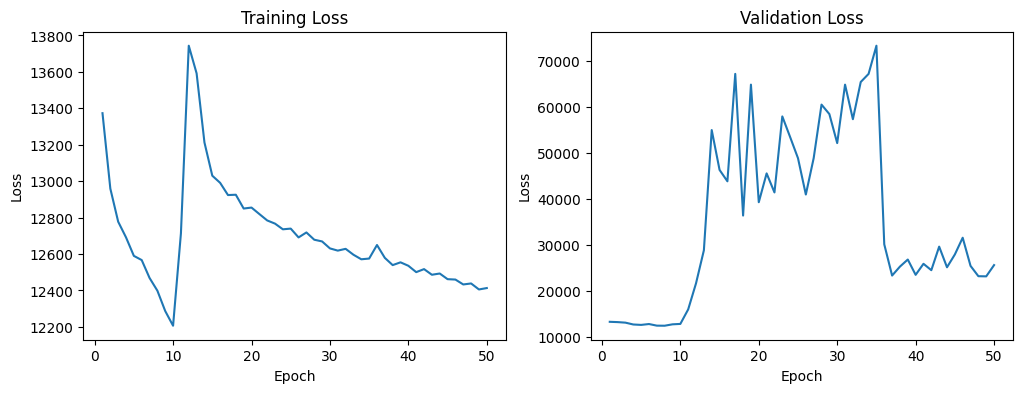

In [24]:
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(1+np.arange(num_epochs), tr_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(1+np.arange(num_epochs), valid_loss)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
# model = Seq2Seq(num_channels=1, num_kernels=64, 
# kernel_size=(3, 3), padding=(1, 1), activation="relu", 
# frame_size=(64, 64), num_layers=3).to(device)
# model.load_state_dict(torch.load("/home/staditya/Desktop/Pushkal/IVP Project/ConvLSTM/walking_50_ep.pth"))

In [ ]:
def collate_test(batch):

    # Last 15 frames are target
    target = np.array(batch)[:,60:]                     
    
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)          
    batch = batch / 255.0                             
    batch = batch.to(device)                          
    return batch, target

# Test Data Loader
test_loader = DataLoader(test_data,shuffle=True, 
                         batch_size=1, collate_fn=collate_test)

In [ ]:
# Get a batch
batch, target = next(iter(test_loader))
print(target.shape)
print(batch.shape)
# Initialize output sequence
output = np.zeros(target.shape, dtype=np.uint8)

# Loop over timesteps
for timestep in range(target.shape[1]):
    inp = batch[:,:,timestep:timestep+60]   
    output[:,timestep]=(model(inp).squeeze(1).cpu().detach())*255.0

In [ ]:
output_save = []
tgt_save = []
for tgt, out in zip(target, output):       # Loop over samples
#     print(tgt.shape)
#     print(out.shape)
    # Write target video as gif
    output_save.append(out)
    tgt_save.append(tgt)
    tgt = np.array(tgt, dtype = 'uint8')
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps = fps)    
        target_gif = gif.getvalue()

    # Write output video as gif
    out = np.array(out, dtype = 'uint8')
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps = fps)    
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif), 
                  widgets.Image(value=output_gif)]))

In [ ]:
model_dir = ""
model_path = os.path.join(model_dir, "walking_50_ep"+".pth")
torch.save(model.state_dict(), model_path)